**1. Load the dataset**

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt

# Load the dataset
weather_data = pd.read_csv('/content/drive/MyDrive/nndl/weather_data.csv')
weather_data['date'] = pd.to_datetime(weather_data['date'])

**2. Preprocess the data**

In [14]:
# Normalize the temperature data
scaler = MinMaxScaler()
weather_data['normalized_temperature'] = scaler.fit_transform(weather_data[['temperature']])

# Split the data into training (70%) and testing (30%) sets
train_data, test_data = train_test_split(
    weather_data[['normalized_temperature']].values, test_size=0.3, shuffle=False
)

here we normalize (scale) the temperatures to a standard range (like shrinking everything to fit between 0 and 1). Then, we split the data into two parts:

Training set: Used to teach the model.

Testing set: Used to check how well the model learned.

**3. Build an LSTM Autoencoder**

In [15]:

# Create sequences for LSTM input
timesteps = 30  # Sequence length for the LSTM
features = 1    # Number of features (temperature)

def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        sequences.append(data[i : i + timesteps])
    return np.array(sequences)

train_sequences = create_sequences(train_data, timesteps)
test_sequences = create_sequences(test_data, timesteps)

# Build the LSTM Autoencoder
input_layer = Input(shape=(timesteps, features))

# Encoder
encoded = LSTM(64, activation='relu', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)

# Decoder
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features))(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

here we create a autoencoder to learn patterns:

The encoder compresses the input data into a smaller, simpler form (latent representation).
The decoder tries to rebuild the original data from that simpler form.

**4. Train the model**

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - loss: 0.1987 - val_loss: 0.0291
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0246 - val_loss: 0.0159
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0145 - val_loss: 0.0098
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0079 - val_loss: 0.0104
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0087 - val_loss: 0.0067
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.0052 - val_loss: 0.0046
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0025 - val_loss: 0.0037
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0

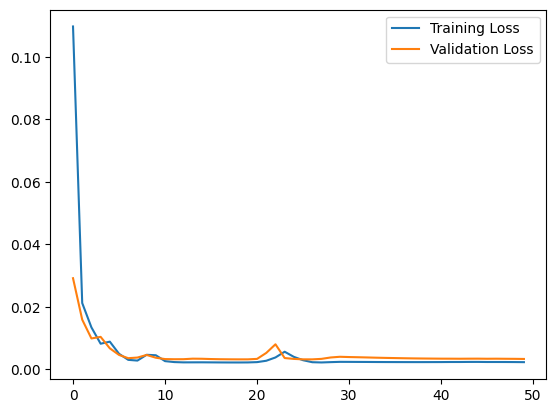

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step


In [16]:
# Train the model
history = autoencoder.fit(
    train_sequences, train_sequences,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Predict on test data
reconstructed = autoencoder.predict(test_sequences)
mse = np.mean(np.power(test_sequences - reconstructed, 2), axis=(1, 2))

We let the model practice on the training data. It keeps trying to rebuild the original temperatures until it gets good at it. We also watch the training progress to ensure it's learning properly.

**5. Anomaly Detection**

In [17]:
# Define anomaly threshold
threshold = np.percentile(mse, 95)  # Top 5% as anomalies

# Identify anomalies
anomalies = mse > threshold

# Adjust dates to match the number of reconstructed sequences
dates = weather_data['date'][-len(test_data):].iloc[timesteps : len(test_sequences) + timesteps]

We ask the model to rebuild the test data.

If the model struggles to rebuild some days (i.e., high error), we treat those days as anomalies.

A threshold is set (e.g., top 5% errors) to decide which errors are big enough to call anomalies.

**6. Visualize the results**

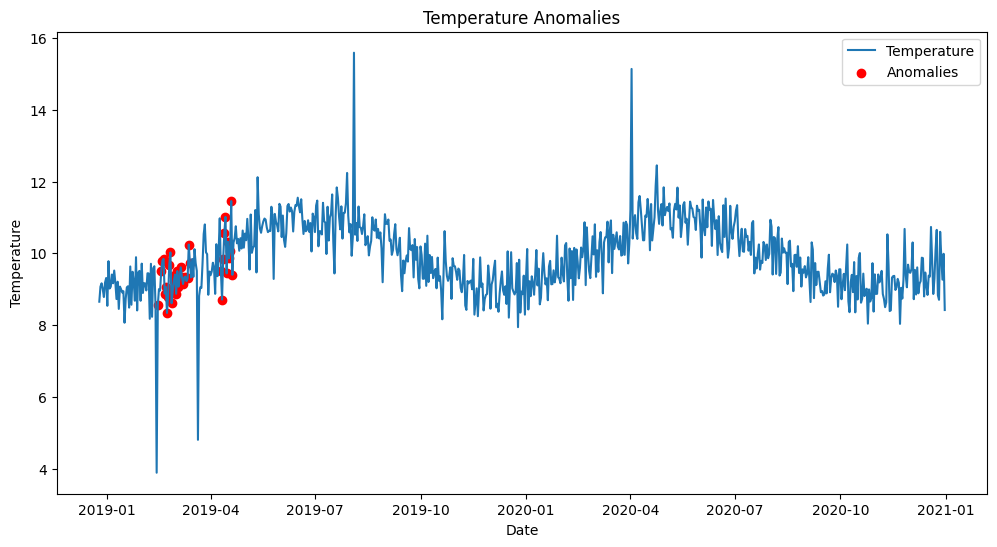

In [18]:
# Plot the temperature and anomalies
plt.figure(figsize=(12, 6))
plt.plot(dates, scaler.inverse_transform(test_data[timesteps : len(test_sequences) + timesteps]), label='Temperature')
plt.scatter(dates[anomalies],
            scaler.inverse_transform(test_data[timesteps : len(test_sequences) + timesteps])[anomalies],
            color='red', label='Anomalies')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Anomalies')
plt.legend()
plt.show()

a graph is made showing the temperatures over time. anomalies are highlighted in red